In [222]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Bidirectional,Conv1D,MaxPooling1D, Input,concatenate
import random

from sklearn.preprocessing import MultiLabelBinarizer
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,f1_score,auc
from sklearn.model_selection import KFold


## Code to import and describe datasets

In [300]:
train_df = pd.read_excel('~/data/training.xlsx',header=1)
ILED2195 = pd.read_excel('~/data/ILED2195_test.xlsx',header=1)
IDED1246 = pd.read_excel('~/data/IDED1246_test.xlsx',header=1)
train_df['Label'] = train_df['Epitope'].map({'Yes':1,'No':0})
ILED2195['Label'] = ILED2195['Epitope'].map({'Yes':1,'No':0})
IDED1246['Label'] = IDED1246['Epitope'].map({'Yes':1,'No':0})

train_df['Peptide'] = train_df.Sequence.tolist() 
ILED2195['Peptide'] = ILED2195.Sequence.tolist() 
IDED1246['Peptide'] = IDED1246.Sequence.tolist() 


In [40]:
def df_describe(df,lb):
     
    y_norm =df["Label"].value_counts(normalize=True).tolist()
    print(df["Label"].value_counts(normalize=False))
    y_norm = [x*100 for x in y_norm]

    g=sns.barplot([0,1], y_norm)
    ax=g

    #annotate axis = seaborn axis
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                    textcoords='offset points')
    _ = g.set_ylim(0,100) #To make space for the annotations
    plt.ylabel('%')
    plt.title('%s\n Epitope Class Distribution'%(lb))
    plt.xticks([0,1],['Not Epitopes','Epitopes'])
    plt.show()
    plt.close()
    print('#Peptide lenght')
    leng = [len(x) for x in df["Sequence"]]
    plt.hist(leng, bins=30,density=True) 

    plt.title('Sequence lenght\n %s Dataset'%(lb))
    #plt.xlabel('AA')
    plt.show()
    plt.close()
    print('Min: ',min(leng))
    print('Max: ',max(leng))
    print('-'*50)

1    555
0    555
Name: Label, dtype: int64


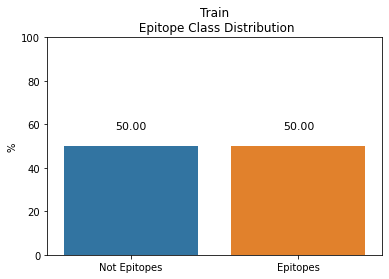

#Peptide lenght


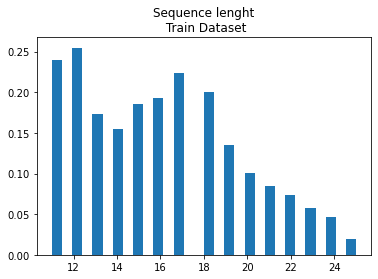

Min:  11
Max:  25
--------------------------------------------------
1    2195
0    2195
Name: Label, dtype: int64


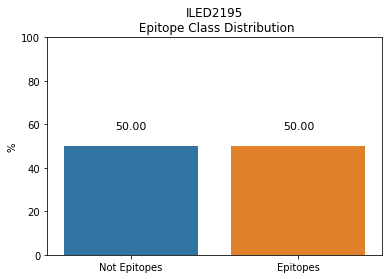

#Peptide lenght


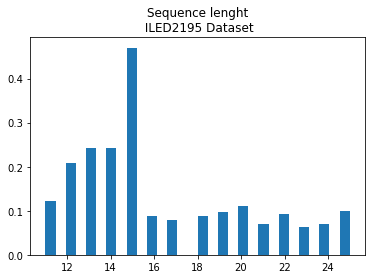

Min:  11
Max:  25
--------------------------------------------------
1    1246
0    1246
Name: Label, dtype: int64


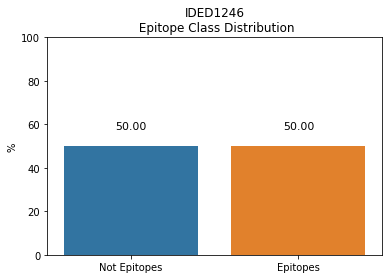

#Peptide lenght


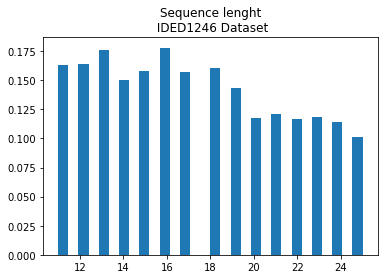

Min:  11
Max:  25
--------------------------------------------------


In [41]:
df_describe(train_df,'Train')
df_describe(ILED2195,'ILED2195')
df_describe(IDED1246,'IDED1246')

## Encoding and preprocessing

In [127]:
aminoacids = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','Z','X','B']

def one_hot_encoder(stringa):

    d = {a: i for i, a in enumerate(aminoacids)}

    x = np.zeros((len(d), len(stringa)))
    x[[d[c] for c in stringa], range(len(stringa))] = 1
    # = np.array(x)
    return x

def one_hot_encoder_emb(stringa):

    char_to_int = dict((c, i) for i, c in enumerate(aminoacids))
    int_to_char = dict((i, c) for i, c in enumerate(aminoacids))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in stringa]
    
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        aa = [0 for _ in range(len(aminoacids))]
        aa[value] = 1
        onehot_encoded.append(aa)
    x = np.array(onehot_encoded)
    return x 


def integer_encoder(stringa):
    char_dict = {}

    for index, val in enumerate(aminoacids):
        char_dict[val] = float(index+1)

    x = [[char_dict[c]] for c in stringa]
    x = np.array(x)
    return x 

def feat_encoder(stringa,feat):
    featfile = '../features/' + feat + '_mod.csv'
    feat = pd.read_csv(featfile,header = 0, sep=',')
    feat = feat.apply(pd.to_numeric,downcast='float')
    feat =feat.to_dict()
    
    x = [[list(feat[c].values()) for c in stringa]]
    
    x = np.array(x)
    return x

def data_encoder(train,test,feat): 
    if feat == 'One-hot': 
        X_train = [one_hot_encoder(x) for x in train.Peptide.values]
        #X_val = [one_hot_encoder(x) for x in validate.Peptide.values]
        X_test = [one_hot_encoder(x) for x in test.Peptide.values]
    elif feat == 'One-hot_emb':
        X_train = [one_hot_encoder_emb(x) for x in train.Peptide.values]
        #X_val = [one_hot_encoder(x) for x in validate.Peptide.values]
        X_test = [one_hot_encoder_emb(x) for x in test.Peptide.values]
    elif feat == 'Integer':
        X_train =[integer_encoder(x) for x in train.Peptide.values]
       # X_val = [integer_encoder(x) for x in validate.Peptide.values]
        X_test = [integer_encoder(x) for x in test.Peptide.values]
    else:
        X_train = [feat_encoder(x,feat) for x in train.Peptide.values]
        #X_val = [feat_encoder(x,feat) for x in validate.Peptide.values]
        X_test = [feat_encoder(x,feat) for x in test.Peptide.values]
    return X_train,X_test

def ml_encoder(ml,X_train,X_test,feat):
    if ml == 'ANN':
        X_train = [x.flatten('F') for x in X_train]
        X_train = np.asarray(X_train)
        #X_val = [x.flatten('F') for x in X_val]
        #X_val = np.asarray(X_val)
        X_test = [x.flatten('F') for x in X_test]
        X_test = np.asarray(X_test)
    else:
        if feat == 'One-hot':
            X_train = np.transpose(np.asarray(X_train), (0, 2, 1))
            X_test = np.transpose(np.asarray(X_test), (0, 2, 1))
            #X_val = np.transpose(np.asarray(X_val), (0, 2, 1))
        elif feat == 'Integer':
            X_train = np.transpose(np.asarray(X_train), (0, 1, 2))
            X_test = np.transpose(np.asarray(X_test), (0, 1, 2))
            #X_val = np.transpose(np.asarray(X_val), (0, 1, 2))
        else:
            X_train = np.asarray(X_train)
            X_train= X_train.transpose(0, 2, 3, 1)
            X_train = np.squeeze(X_train, axis=(3,))
            X_test = np.asarray(X_test)
            X_test= X_test.transpose(0, 2, 3, 1)
            X_test = np.squeeze(X_test, axis=(3,))
            #X_val = np.asarray(X_val)
           # X_val= X_val.transpose(0, 2, 3, 1)
           # X_val = np.squeeze(X_val, axis=(3,))
    return X_train,X_test

## Deep learning models

In [176]:
def cnn_model(X_train):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5,strides=1,activation='relu',padding='same',input_shape=(X_train.shape[1], X_train.shape[2], )))
    
    model.add(GlobalMaxPooling1D())
    model.add(Conv1D(64, kernel_size=5,strides=1, activation='relu',padding='same'))
    model.add(GlobalMaxPooling1D())
    
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

def cnn_model2(X_train):
    model.add(Conv1D(128, 5,strides=1, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2],)))
    model.add(GlobalMaxPooling1D(pool_size=2,strides=1))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model
    
def ann_model(X_train):
    model = Sequential()
    model.add(Dense(units=256,kernel_initializer='uniform',activation='relu',input_dim=X_train.shape[1]))
    model.add(Dropout(rate=0.4))
    model.add(Dense(units=256,kernel_initializer='uniform',activation='relu')  )
    model.add(Dropout(rate=0.4))
    model.add(Dense(units=128,kernel_initializer='uniform',activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
    model.compile(optimizer='adam', loss = "binary_crossentropy", metrics = ['accuracy'])
    return model
def Bi_lstm_model(X_train):
    model = Sequential()
    model.add(Bidirectional(LSTM(400,return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(200),input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss = "binary_crossentropy", metrics = ['accuracy'])
    return model
def lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.3))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dropout(rate=0.3))
    model.add(LSTM(units=100,return_sequences=False))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer='adam', loss = "binary_crossentropy", metrics = ['accuracy'])
    return model


def ann_emb_model(): 
    embedding_dim = 50
    model = Sequential()
    model.add(Embedding(input_dim=21, output_dim=embedding_dim, input_length=25))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

def lstm_emb_model():
    model = Sequential()
    model.add(Embedding(21, 128, input_length=max_length))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss = "binary_crossentropy", metrics = ['accuracy'])
    return model


In [152]:
def pep_pad(df,max_length):
    epilist =[]
    for x in df.Sequence.tolist():
        txt = x.ljust(max_length, 'X')[:max_length]
        epilist.append(txt)
    df['Peptide'] =  epilist 
    return df

max_length = 25
train_df = pep_pad(train_df,max_length)
ILED2195 = pep_pad(ILED2195,max_length)
IDED1246 = pep_pad(IDED1246,max_length)

y_train = train_df.Label.values
y_ILED2195= ILED2195.Label.values
y_IDED1246 = IDED1246 .Label.values

#X_train, X_val, X_test = data_encoder(train,validate,test,'One-hot')


## 5-fold Cross validation

In [185]:
acc_per_fold = []
loss_per_fold = []


# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

inputs = train_df 
targets = y_train


for train, test in kfold.split(inputs, targets):
  X_train= inputs.iloc[train]
  
  
  X_test= inputs.iloc[test]

  Y_train = targets.iloc[train]
  Y_test = targets.iloc[test]

  X_train,X_test =data_encoder(X_train,X_test,'One-hot')
  
  X_train, X_test =ml_encoder('LSTM',X_train,X_test,'One-hot')
  #train_pad = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
  #val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
  #test_pad = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
  model = Bi_lstm_model(X_train)
  history = model.fit(X_train,targets[train],
              batch_size=256,
              epochs=200,
              validation_data=(X_test, targets[test]),
              callbacks=[es], verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(X_test, targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 00015: early stopping
Score for fold 1: loss of 0.7105609178543091; accuracy of 49.54954981803894%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 00006: early stopping
Score for fold 2: loss of 0.6191149353981018; accuracy of 68.91891956329346%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 00014: early stopping
Score for fold 3: loss of 0.5696873068809509; accuracy of 70.7207202911377%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 00007: early stopping
Score for fold 4: loss of 0.6078630685806274; accuracy of 66.2162184715271%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 00007: early stopping
Score for fold 5: loss of 0.5564047694206238; accuracy of 73.42342734

In [186]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7105609178543091 - Accuracy: 49.54954981803894%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6191149353981018 - Accuracy: 68.91891956329346%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5696873068809509 - Accuracy: 70.7207202911377%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6078630685806274 - Accuracy: 66.2162184715271%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5564047694206238 - Accuracy: 73.42342734336853%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.76576709747314 (+- 8.441591098363974)
> Loss: 0.6127261996269227
-------------------------------

### Trying with embedding and different cross-fold validation split

In [282]:
def one_hot_encoder(data) :
	char_to_int = dict((c, i) for i, c in enumerate(aminoacids))
	int_to_char = dict((i, c) for i, c in enumerate(aminoacids))
	# integer encode input data
	integer_encoded = [char_to_int[char] for char in data]
	#print(integer_encoded)
	# one hot encode
	
	return integer_encoded



In [301]:
train_df2 = pep_pad(train_df,max_length)
ILED2195_2 = pep_pad(ILED2195,max_length)
IDED1246_2 = pep_pad(IDED1246,max_length)

trainLines = train_df2['Peptide'].tolist()
trainLabels = train_df2['Label'].tolist()


In [302]:
length = 25

print(len(trainLines))
encodedlist = []
for pep in trainLines:
	encoded = one_hot_encoder(pep)
	encodedlist.append(np.array(encoded))


#train_padded = pad_sequences(encodedlist, maxlen=length, padding='post')

trainX = np.array(encodedlist)
trainX.shape

1110


(1110, 25)

In [308]:
def CNN_emb_model(length, vocab_size):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, 100)(inputs3)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	#print(model.summary())
	#plot_model(model, show_shapes=True, to_file='multichannel.png')
	return model

In [309]:
vocab_size = 21
model = CNN_emb_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], np.array(trainLabels), epochs=30, batch_size=16)

Epoch 1/30
70/70 [==============================] - 11s 136ms/step - loss: 0.6795 - accuracy: 0.5649
Epoch 2/30
70/70 [==============================] - 7s 94ms/step - loss: 0.5820 - accuracy: 0.6919
Epoch 3/30
70/70 [==============================] - 7s 98ms/step - loss: 0.4989 - accuracy: 0.7523
Epoch 4/30
70/70 [==============================] - 6s 92ms/step - loss: 0.4826 - accuracy: 0.7703
Epoch 5/30
70/70 [==============================] - 7s 98ms/step - loss: 0.4294 - accuracy: 0.8045
Epoch 6/30
70/70 [==============================] - 7s 106ms/step - loss: 0.4108 - accuracy: 0.8072
Epoch 7/30
70/70 [==============================] - 6s 93ms/step - loss: 0.3648 - accuracy: 0.8333
Epoch 8/30
70/70 [==============================] - 7s 101ms/step - loss: 0.3327 - accuracy: 0.8685
Epoch 9/30
70/70 [==============================] - 7s 102ms/step - loss: 0.3071 - accuracy: 0.8667
Epoch 10/30
70/70 [==============================] - 7s 99ms/step - loss: 0.2716 - accuracy: 0.8964
Epoc

In [310]:
encodedlist = []
testLines = ILED2195_2['Peptide'].tolist()
testLabels = ILED2195_2['Label'].tolist()
for pep in testLines:
	encoded = one_hot_encoder(pep)
	encodedlist.append(np.array(encoded))



#train_padded = pad_sequences(encodedlist, maxlen=length, padding='post')

testX = np.array(encodedlist)
loss, acc = model.evaluate([testX,testX,testX],np.array(testLabels), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 58.246017


In [311]:
train_df = pep_pad(train_df,max_length)
ILED2195 = pep_pad(ILED2195,max_length)
IDED1246 = pep_pad(IDED1246,max_length)

y_train = train_df.Label.values
y_ILED2195= ILED2195.Label.values
y_IDED1246 = IDED1246 .Label.values


acc_per_fold = []
loss_per_fold = []


# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

inputs = train_df 
targets = y_train

length = 25




for train, test in kfold.split(inputs, targets):
  X_train= inputs.iloc[train]
  
  X_test= inputs.iloc[test]

  Y_train = targets[train]
  Y_test = targets[test]

  
  trainlist = []
  testlist=[]
  for pep in X_train.Peptide:
    encoded = one_hot_encoder(pep)
    trainlist.append(np.array(encoded))

  X_train = np.array(trainlist)
  for pep in X_test.Peptide:
    encoded = one_hot_encoder(pep)
    testlist.append(np.array(encoded))
  trainX = np.array(trainlist)
  testX = np.array(testlist)

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
  model = CNN_emb_model(length, vocab_size)
  model.fit([trainX,trainX,trainX], Y_train, epochs=200, batch_size=8,validation_data=([testX,testX,testX], Y_test),callbacks=[es], verbose=0)

  loss, acc = model.evaluate([trainX,trainX,trainX], Y_train, verbose=0)
  
  
  print('Train Accuracy: %f' % (acc*100))
 
  # evaluate model on test dataset dataset
  loss, acc = model.evaluate([testX,testX,testX],Y_test, verbose=0)
  print('Test Accuracy: %f' % (acc*100))

  # Generate generalization metrics
  
  acc_per_fold.append(acc * 100)
  loss_per_fold.append(loss)

  # Increase fold number
  fold_no = fold_no + 1
  #print('*'*50)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 00006: early stopping
Train Accuracy: 89.789790
Test Accuracy: 62.162161
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 00005: early stopping
Train Accuracy: 87.987989
Test Accuracy: 69.369370
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 00004: early stopping
Train Accuracy: 82.282281
Test Accuracy: 65.765768
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 00006: early stopping
Train Accuracy: 91.391391
Test Accuracy: 63.963968
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 00006: early stopping
Train Accuracy: 86.986983
Test Accuracy: 64.864868
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 00005: early stop

In [312]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8508868217468262 - Accuracy: 62.162160873413086%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6044377088546753 - Accuracy: 69.36936974525452%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6507459878921509 - Accuracy: 65.76576828956604%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6845406889915466 - Accuracy: 63.9639675617218%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.7592862844467163 - Accuracy: 64.86486792564392%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.7259695529937744 - Accuracy: 69.36936974525452%
------------------------------------------------------------------------